In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.initializers import he_normal
%matplotlib inline

# Display only top 5 and bottom 5 rows
pd.set_option('display.max_rows', 10)

Using TensorFlow backend.


In [2]:
# Set random seed for reproducibility
# Note: CuDNN is usually non-deterministic
# (can't determine which of the ~3000 threads finish earlier)
# And floating points reduction is not perfectly associative due to ULP rounding
import numpy as np
np.random.seed(1337)
import tensorflow as tf
tf.set_random_seed(1337)

In [3]:
df_train = pd.read_csv('./data/train_aWnotuB.csv', parse_dates=[0], infer_datetime_format=True)
df_train

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


# Preprocessing

In [4]:
train = df_train.pivot(index='DateTime',columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


## Remove Nan (0 vehicle)

In [5]:
train = train.fillna(0)

## Normalize the data on 0, 1

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [7]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
train[train.columns] = scaler.fit_transform(train[train.columns])

In [9]:
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,0.066225,0.106383,0.044693,0.000000
2015-11-01 01:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,0.000000
...,...,...,...,...
2017-06-30 19:00:00,0.662252,0.702128,0.178771,0.305556
2017-06-30 20:00:00,0.602649,0.723404,0.167598,0.833333
2017-06-30 21:00:00,0.562914,0.638298,0.150838,0.444444


# Generate rolling forecast features

In [10]:
nb_forecast_per_junction = 24 * (31 + 31 + 30 + 31) # Days in jul + aug + sep + oct

In [11]:
nb_forecast_per_junction

2952

In [12]:
nb_forecast_per_junction * 4

11808

That will certainly not fit in the GPU VRAM --> We will get inspiration from seq2seq models and do a sliding window of time that matches a week.

In [13]:
num_feats = 4
seq_len = 24 # We predict 24 hours
num_outputs = 4
num_hidden = 7 # We keep the week
bs = 1024
epochs = 500
pred_len = int(nb_forecast_per_junction / seq_len)
assert nb_forecast_per_junction % seq_len == 0 # Check that we can split forecast into even sequences
print(pred_len)
LOG_PATH = "checkpoints/" + time.strftime("%Y-%m-%d_%H%M-")+"seq2seq-attns-GRU.hdf5"

123


We originally had 14592 rows, we will generate sequences of predictions from it.

In [14]:
def make_input_seqs(data, seq_len, train_split=0.9):
    seq_len = seq_len + 1
    result = []
    for index in range(len(data) - seq_len):
        result.append(data[index: index + seq_len, :])
    result = np.array(result) # shape (14423, 168, 4)
    train_ind = round(train_split * result.shape[0])
    train = result[:int(train_ind), :, :]
    x_train = train[:, :-1, :]
    y_train = train[:, -1, :]
    x_test = result[int(train_ind):, :-1, :]
    y_test = result[int(train_ind):, -1, :]

    return [x_train, y_train, x_test, y_test]

In [15]:
X_train, y_train, X_test, y_test = make_input_seqs(train.values, seq_len)

# Generate model

## Loss function

In [16]:
import keras.backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

## Neural net

In [17]:
from keras.optimizers import adam, rmsprop

In [18]:
# adam = adam(clipvalue=0.5) # Clip to avoid exploding gradients
rmsprop = rmsprop(lr = 0.0004, decay = 0.002)

In [19]:
from keras.layers import *
from keras.layers.core import *
from keras.layers.recurrent import *
from keras.models import *
from keras.activations import *

In [20]:
def attention_n_days_ago(inputs, days_ago):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = days_ago * 24
    
    # We compute the attention over the seq_len
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    
    # Now we convolute so that it average over the whole time window
    feats_depth = int(inputs.shape[2])
    avg = Lambda(lambda x: K.expand_dims(x, axis = 1))(inputs)
    avg = SeparableConv2D(feats_depth, (1,1))(avg)
    avg = Lambda(lambda x: K.squeeze(x, 1))(avg)
    
    
    a_probs = Permute((2, 1), name='attn_' + str(days_ago) + '_days')(avg)
    # out = Multiply(name='attn_mul_'+ str(days_ago) +'_days')([inputs, a_probs])
    out = Concatenate(name='attention_cat_'+ str(days_ago) +'_days')([inputs, a_probs])
    return out

In [21]:
def Net(num_feats, seq_len, num_hidden, num_outputs):
    x = Input((seq_len, num_feats))

    # Encoder RNNs
    enc = GRU(seq_len,
               return_sequences=True)(x)
    
    # Attention decoders
    attention_1d = attention_n_days_ago(enc, 1)
    attention_1w = attention_n_days_ago(enc, 7)
    attention_1m = attention_n_days_ago(enc, 30)
    attention_1q = attention_n_days_ago(enc, 92)
    attention_1y = attention_n_days_ago(enc, 365)
    
    att = Concatenate(name='attns_cat', axis = 1)([attention_1d,
                                                   attention_1w,
                                                   attention_1m,
                                                   attention_1q,
                                                   attention_1y])
    
    # How to merge? concat, mul, add, use Dense Layer or Depthwise convolution ?
    att = Permute((2, 1))(att)
    att = Dense(seq_len, activation=None)(att)
    att = Lambda(lambda x: softmax(x, axis = 1))(att) # Flatten along the concat axis
    
    # Decoder RNN
    dec = GRU(num_hidden,
               return_sequences=False)(att)

    # Regressor
    # Note that Dense is automatically TimeDistributed in Keras 2
    out = Dense(num_outputs, activation=None)(dec) # no activation for regression
    
    model = Model(inputs=x, outputs=out)
                          
    model.compile(loss= root_mean_squared_error, optimizer= rmsprop)
    return model

In [22]:
model = Net(num_feats, seq_len, num_hidden, num_outputs)

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24, 4)        0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 24, 24)       2088        input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 24, 24)    0           gru_1[0][0]                      
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1, 24, 24)    0           gru_1[0][0]                      
__________________________________________________________________________________________________
lambda_5 (

### Callbacks

In [24]:
from keras.callbacks import History, ModelCheckpoint, CSVLogger, EarlyStopping

In [25]:
history = History()
checkpointer = ModelCheckpoint(filepath= LOG_PATH,
                               verbose=1, save_best_only=False)
csv_logger = CSVLogger("checkpoints/" + time.strftime("%Y-%m-%d_%H%M-")+'training.log')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

# Training

In [26]:
model.fit(X_train, y_train,
          batch_size=bs,
          epochs=epochs,
          validation_split=0.05,
          callbacks=[history,checkpointer,csv_logger,early_stop])

Train on 12454 samples, validate on 656 samples
Epoch 1/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.1847Epoch 00001: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.1841 - val_loss: 0.3146
Epoch 2/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.1705Epoch 00002: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.1699 - val_loss: 0.3012
Epoch 3/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.1581Epoch 00003: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.1576 - val_loss: 0.2880
Epoch 4/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.1458Epoch 00004: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [====================

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0784Epoch 00014: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0781 - val_loss: 0.1618
Epoch 15/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0764Epoch 00015: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0763 - val_loss: 0.1537
Epoch 16/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0742Epoch 00016: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0741 - val_loss: 0.1466
Epoch 17/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0720Epoch 00017: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0719 - val_loss: 0.1408
Ep

12288/12454 [============================>.] - ETA: 0s - loss: 0.0602Epoch 00027: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0603 - val_loss: 0.1024
Epoch 28/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0597Epoch 00028: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0597 - val_loss: 0.1025
Epoch 29/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0590Epoch 00029: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0590 - val_loss: 0.0979
Epoch 30/500

12288/12454 [============================>.] - ETA: 0s - loss: 0.0583Epoch 00030: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0583 - val_loss: 0.0987
Ep

Epoch 41/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0509Epoch 00041: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0509 - val_loss: 0.0884
Epoch 42/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0502Epoch 00042: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0503 - val_loss: 0.0897
Epoch 43/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0497Epoch 00043: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0498 - val_loss: 0.0875
Epoch 44/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0494Epoch 00044: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0494 - val_l

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0464Epoch 00054: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0463 - val_loss: 0.0836
Epoch 55/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0461Epoch 00055: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0462 - val_loss: 0.0826
Epoch 56/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0461Epoch 00056: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0460 - val_loss: 0.0818
Epoch 57/500

12288/12454 [============================>.] - ETA: 0s - loss: 0.0458Epoch 00057: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0459 - val_loss: 0.0818
Ep

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0450Epoch 00067: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0450 - val_loss: 0.0793
Epoch 68/500

11264/12454 [==========================>...] - ETA: 0s - loss: 0.0447Epoch 00068: saving model to checkpoints/2017-11-18_1952-seq2seq-attns-GRU.hdf5

12454/12454 [==============================] - ETA: 0s - loss: 0.0448 - val_loss: 0.0790
Epoch 00068: early stopping


# Validation

## Validation by feeding truth values

In [27]:
def plot_preds(y_truth, y_pred):
    for junction in range(4):
        plt.figure
        plt.plot(y_truth[:,junction], color = 'blue', label = 'Real traffic')
        plt.plot(y_pred[:,junction], color = 'orange', label = 'Predicted traffic')
        plt.title('Traffic Forecasting at junction %i' % (junction+1))
        plt.xlabel('Number of hours from Start')
        plt.ylabel('Traffic')
        plt.legend()
        plt.show()

### Prediction

In [28]:
y_pred = model.predict(X_test)

In [29]:
y_pred.shape

(1457, 4)

### Plot & score

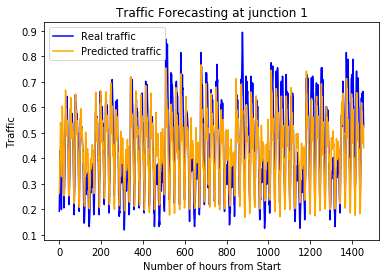

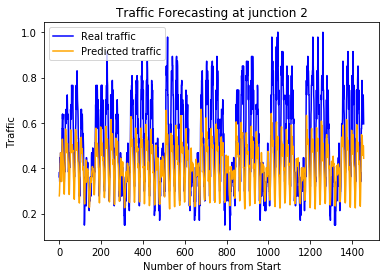

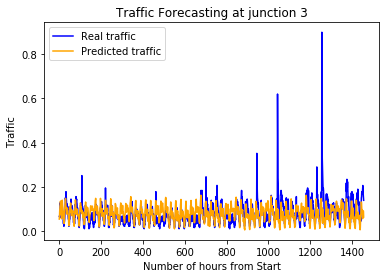

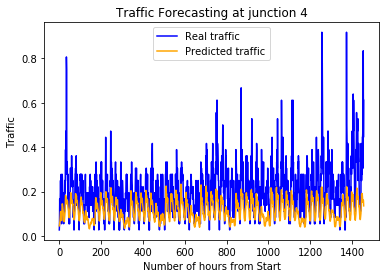

In [30]:
plot_preds(y_test, y_pred)

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [32]:
rmse(y_test, y_pred)

0.11948994673433476

## Validation by feeding predicted values

In [33]:
def pred_seq(model, to_pred, window_size):
    num_preds = to_pred.shape[0]
    current = to_pred[0]
    predicted = []
    for i in range(num_preds):
        predicted.append(model.predict(current[np.newaxis,:,:])[0,:])
        current = current[1:]
        current = np.insert(current, [window_size-1], predicted[-1], axis=0)
    return np.asarray(predicted)

In [34]:
def pred_seq_multi(model, to_pred, window_size, pred_len):
    prediction_seqs = []
    for i in range(int(len(to_pred)/pred_len)):
        current = to_pred[i * pred_len]
        predicted = []
        for j in range(pred_len):
            predicted.append(model.predict(current[np.newaxis,:,:])[0,:])
            current = current[1:]
            current = np.insert(current, window_size-1, predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return np.asarray(predicted)

### Predictions

In [35]:
seqpreds = pred_seq(model, X_test, seq_len)

In [36]:
seqpreds.shape

(1457, 4)

### Plot & score

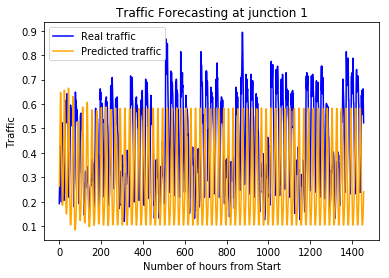

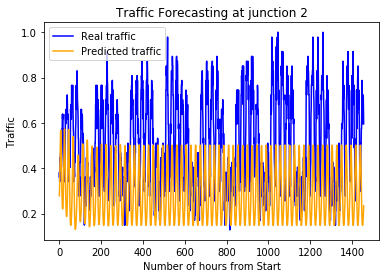

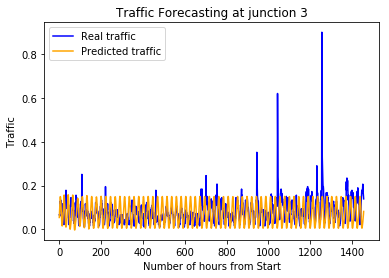

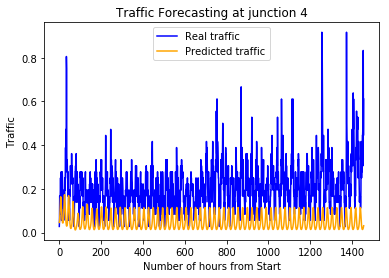

In [37]:
plot_preds(y_test, seqpreds)

In [38]:
rmse(y_test, seqpreds)

0.23633792335798046